# AGU PDS Cloud Science Demo

In [1]:
# Import packages
import glob
from datetime import datetime
from obspy.core import read
from matplotlib import pyplot as plt
import numpy as np
import os
import requests
import datetime as dt
from pprint import pprint

In this demo, we will show how to download seismic data from the apollo missions and run a seismic detector code on it. 

In this example, we will use xa.s12.00.mhz.1970-03-25

We will show operations on how to conduct research using a single piece of selected data without having to explicitly download it. 

## Pull test data from the PDS API

In [60]:
# The peppi method from the PDS API is required to look at the packages
import pds.peppi as pep
client = pep.PDSRegistryClient()

In [61]:
# Get a list of seimic data products matching the Apollo PSE seismic data for the day of seismic data that we're interested in.
# We can use the datetime format and the method strptime to get the correct day
period_of_interest_start = datetime.fromisoformat('1970-03-24T00:00:00.0000000+00:00')
period_of_interest_stop = datetime.fromisoformat('1970-03-25T00:00:00.000000+00:00')

# Use the the .after and .before methods to only isolate the day that we're interested in
# NOTE: the api does not filter subsecond
products = pep.Products(client).of_collection("urn:nasa:pds:apollo_pse:data_seed::1.0").after(period_of_interest_start).before(period_of_interest_stop)


In [62]:
[(p.id, seismic_data_products[0].properties['apollo:Seismic_Parameters.apollo:channel'], p.properties["apollo:Seismic_Parameters.apollo:pse_data_type"], p.properties['pds:Time_Coordinates.pds:start_date_time'], p.properties['pds:Time_Coordinates.pds:stop_date_time']) for p in  products]

[('urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.082.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-23T00:00:00.551Z'],
  ['1970-03-24T00:00:01.758547Z']),
 ('urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mh1.1970.082.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-23T00:00:00.626Z'],
  ['1970-03-24T00:00:01.833547Z']),
 ('urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mh2.1970.082.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-23T00:00:00.645Z'],
  ['1970-03-24T00:00:01.852547Z']),
 ('urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mhz.1970.082.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-23T00:00:00.664Z'],
  ['1970-03-24T00:00:01.871547Z']),
 ('urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.083.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-24T00:00:00.079317Z'],
  ['1970-03-25T00:00:01.286864Z']),
 ('urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mh1.1970.083.0::1.0',
  ['ATT'],
  ['waveform'],
  ['1970-03-24T00:00:00.154317Z'],
  ['1970-03-25T00:00:01.814694Z']),
 ('urn:nasa:pd

In [63]:
# In this particular case, we only care about the seismic data, so we will filter based on that parameter
seismic_data_products = [p for p in products if p.properties["apollo:Seismic_Parameters.apollo:pse_data_type"][0] == "waveform"]

# See the number of products available for this time period
print(f'{len(seismic_data_products)} Data Product(s) Available!')

12 Data Product(s) Available!


In [64]:
# Each seismic data products has a significant amount of information that we can choose to filter by
# Let's take a look at the first product
pprint(seismic_data_products[0].properties)

{'_package_id': ['139b33e5-bc88-455e-a96c-e13d18c2c821'],
 'alternate_ids': ['urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.082.0::1.0',
                   'urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.082.0'],
 'apollo:ASCII_Equivalent.apollo:ascii_equivalent_file_name': ['xa.s12..att.1970.082.0.a.csv'],
 'apollo:Metadata_Location.apollo:metadata_file_name': ['dataless.xa.0.seed'],
 'apollo:Observation_Information.apollo:product_type': ['Mini-SEED'],
 'apollo:Seismic_Parameters.apollo:channel': ['ATT'],
 'apollo:Seismic_Parameters.apollo:pse_data_type': ['waveform'],
 'apollo:Seismic_Parameters.apollo:sample_count': ['143103'],
 'apollo:Seismic_Parameters.apollo:sampling_rate': ['1.65625'],
 'apollo:Seismic_Parameters.apollo:station': ['S12'],
 'description': ['First release to Planetary Data System'],
 'lid': ['urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.082.0'],
 'lidvid': ['urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.082.0::1.0'],
 'ops:Data_File_Info.ops:c

Wow, this is a lot of information! For our uses though, we only really care about the information related to the apollo missions, which starts with the text string "apollo"


## Let's filter our results

In specific, we are interested in looking at only seismic data in the **miniseed** standard format, for **Apollo 12** for this day, and only in the **vertical direction broadband** seismic instrument. The information can be found in these labels: 

`apollo:Observation_Information.apollo:product_type` = **'Mini-SEED'**

`apollo:Seismic_Parameters.apollo:station` = **'S12'**

`apollo:Seismic_Parameters.apollo:channel` = **'MHZ'**

In [69]:
# You can double check to make sure that the labels correspond to what we're looking for
print({p.properties['apollo:Observation_Information.apollo:product_type'][0] for p in seismic_data_products})
print({p.properties['apollo:Seismic_Parameters.apollo:station'][0] for p in seismic_data_products})
print({p.properties['apollo:Seismic_Parameters.apollo:channel'][0] for p in seismic_data_products})

{'Mini-SEED'}
{'S12'}
{'MHZ', 'MH2', 'ATT', 'MH1'}


We can see that the first product that we selected does not correspond to the broadband vertical channel. In fact, this corresponds to the dataless miniseed metadata file. It's an important file that is used to conduct particular processing to the data, but it's not what we need at the moment! Let's filter the data products based on our parameters.

In [70]:
# Conduct filtering
type_param = "Mini-SEED"
sta_param = "S12"
chan_param = "MHZ"

S12_MHZ_seismic_data_products = [p for p in seismic_data_products if p.properties["apollo:Seismic_Parameters.apollo:channel"][0] == chan_param]

print(f'{len(S12_MHZ_seismic_data_products)} Data Product(s) Available! Success!')

3 Data Product(s) Available! Success!


# Plot the data

Using the Python library Obspy, we can look at the data without having to actually download it by pointing to its url!

The url can be found using the `ops:Data_File_Info.ops:file_ref` parameter

In [52]:
url_paths = [p.properties['ops:Data_File_Info.ops:file_ref'][0] for p in S12_MHZ_seismic_data_products]
print(url_paths)

['https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/082/xa.s12.00.mhz.1970.082.0.mseed', 'https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/083/xa.s12.00.mhz.1970.083.0.mseed', 'https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/084/xa.s12.00.mhz.1970.084.0.mseed']


In [71]:
# Let's read in the streams and trace using obspy
from obspy.core import Stream, Trace, UTCDateTime
st = Stream()
for url_path in url_paths:
    st += read(url_path)

st = st.slice(starttime=UTCDateTime(period_of_interest_start), endtime=UTCDateTime(period_of_interest_stop)).merge()

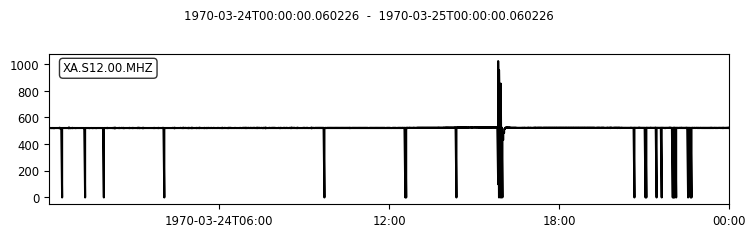

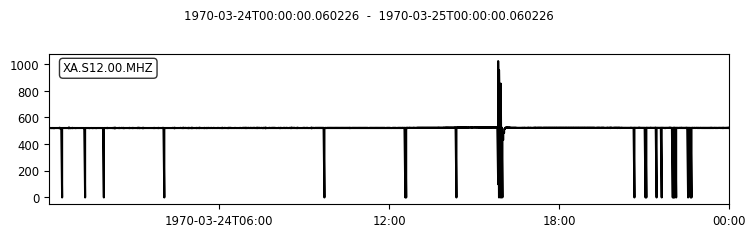

In [72]:
st.plot()

In [73]:
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-03-24T00:00:00.060226Z - 1970-03-25T00:00:00.060226Z | 6.6 Hz, 572401 samples (masked)

In [74]:
# We can look at the miniseed header trace and see that it matches the pds label 
tr = st[0]
tr.stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-03-24T00:00:00.060226Z
         endtime: 1970-03-25T00:00:00.060226Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572401
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 87, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 356352})
      processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(1970, 3, 25, 0, 0, 0, 60226)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(1970, 3, 24, 0, 0, 0, 60226))']

In [94]:
channame = tr.stats.channel
print(f'The channel name is {channame}')
day = trace_start.datetime.strftime("%Y-%m-%d")
print(f'The day used is {day}')

The channel name is MHZ
The day used is 1970-03-25


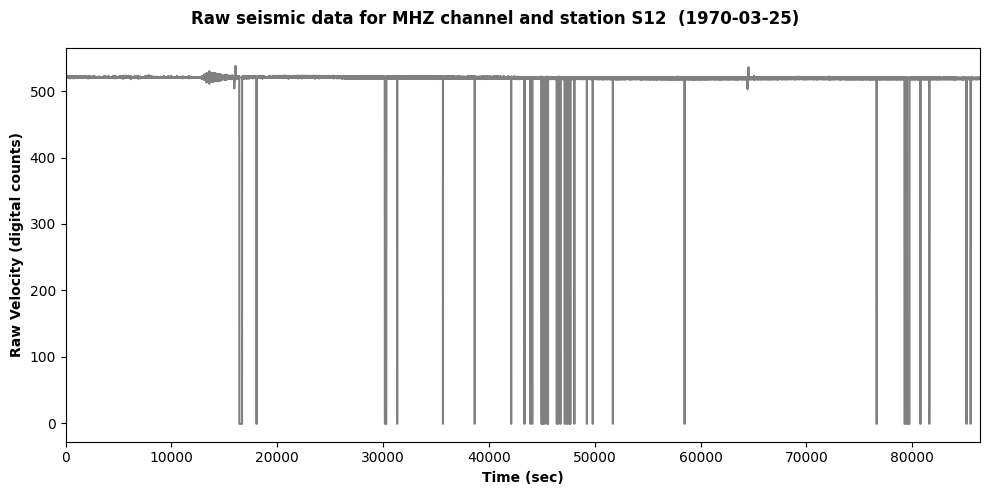

In [95]:
# Plot the raw data
fig = plt.figure(figsize=(10, 5))
# Plot the raw data
ax0 = plt.subplot(1, 1, 1)
ax0.plot(tr.times(), tr.data, color='gray')
ax0.set_xlim((tr.times()[0], tr.times()[-1]))
ax0.set_xlabel('Time (sec)', fontweight='bold')
ax0.set_ylabel('Raw Velocity (digital counts)', fontweight='bold')
fig.suptitle(f'Raw seismic data for {channame} channel and station {station}  ({day})', fontweight='bold')
fig.tight_layout()

# Process the data from machine counts to physical units

In [60]:
# Import some additional libraries
from obspy.signal.invsim import cosine_taper
from scipy.interpolate import interp1d
from obspy import read_inventory
import datetime as dt

In order to process the data from machine counts to physical units, we'll need something called a *dataless seed*, which is a type of seed file that only contains metadata. This is a standalone file with the metadata file name:

`apollo:Metadata_Location.apollo:metadata_file_name` = **dataless.xa.0.seed**

The function that we need to use from osbpy is called `read_inventory`, which works similar to (unlike `obspy.read`) without having to download the file. 

In [103]:
seismic_metadata_products = [p for p in products if p.properties["apollo:Seismic_Parameters.apollo:pse_data_type"][0] == "metadata"]
url_dataless = seismic_metadata_products[0].properties['ops:Data_File_Info.ops:file_ref'][0]
print(url_dataless)

https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/metadata/dataless.xa.0.seed


In [104]:
# Import some subroutines required for the data processing
def running_median(seq, win):
    """
    Conducts a running median on the data

    :param seq: [Vector] Input data
    :param win: [Integer] Size of the window (in samples)
    """

    samples = np.arange(len(seq))
    medians = []

    window_middle = int(np.ceil(win / 2))

    for ind in np.arange(len(seq)):

        if ind <= window_middle:
            medians.append(np.median(abs(seq[0:win])))

        if ind >= len(seq) - window_middle:
            medians.append(np.median(abs(seq[len(seq) - win:len(seq)])))

        if window_middle < ind < len(seq) - window_middle:
            medians.append(np.median(abs(seq[ind - int(np.floor(win / 2)):ind + int(np.floor(win / 2))])))

    return np.array(medians)


def despike(input_t, input_d, fs):
    """
    Despikes the data according to Budlow 2005

    :param input_t: [Vector] Interpolated time
    :param input_d: [Vector] Interpolated data
    :param fs: [Float] Sampling frequency
    :param instrument_type: [String] Type of instrument [lp = long period, sp = short period]
    """

    # Compute a running median on the data
    # The window size should be 2 minutes (120 seconds) and odd
    window_size = int(fs * 120)
    if window_size % 2 == 0:
        window_size = window_size + 1
    med = running_median(input_d, window_size)

    # Find values greater than 5 times the running median
    med_multiplier = 5.
    indices_to_remove = []
    for ind in np.arange(len(input_d)):
        if input_d[ind] > abs(med[ind] * med_multiplier) or input_d[ind] < -1 * abs(med[ind] * med_multiplier):
            indices_to_remove.append(ind)

    # Remove those values from the time and data
    input_t_del = np.delete(input_t, indices_to_remove)
    input_d_del = np.delete(input_d, indices_to_remove)

    # If we remove the last value in the dat, we run into trouble because it can't finish interpolation
    # If it's missing, append a zero value to the data at the end. We have a total of four cases.
    # Missing beginning
    if not input_t_del[0] == input_t[0] and input_t_del[-1] == input_t[-1]:
        input_t_del_fin = np.insert(input_t_del, 0, input_t[0])
        input_d_del_fin = np.insert(input_d_del, 0, 0)

    # Missing end
    if input_t_del[0] == input_t[0] and not input_t_del[-1] == input_t[-1]:
        input_t_del_fin = np.append(input_t_del, input_t[-1])
        input_d_del_fin = np.append(input_d_del, 0)

    # Both missing
    if not input_t_del[0] == input_t[0] and not input_t_del[-1] == input_t[-1]:
        input_t_del_fixbeg = np.insert(input_t_del, 0, input_t[0])
        input_d_del_fixbeg = np.insert(input_d_del, 0, 0)
        input_t_del_fin = np.append(input_t_del_fixbeg, input_t[-1])
        input_d_del_fin = np.append(input_d_del_fixbeg, 0)

    # Nothing missing
    if input_t_del[0] == input_t[0] and input_t_del[-1] == input_t[-1]:
        input_t_del_fin = input_t_del
        input_d_del_fin = input_d_del

    # Interpolate over the missing values
    # We can call on our original input_t variable
    f2 = interp1d(input_t_del_fin, input_d_del_fin)
    d_interp2 = f2(input_t)

    return d_interp2

In [112]:
from obspy.signal.invsim import cosine_taper
from obspy.core.inventory.inventory import read_inventory
from scipy.interpolate import interp1d

def process_data(st, dataless_seed):
    """
    Processes the data: removes mean, tapers, and removes the instrument response (converting it to physical units)
    
    :param Stream: [obspy.core.Stream] obspy input stream
    :param dataless_seed: [str] Path to the dataless seed, which is required for removing the instrument response
    """
    tr = st[0]
    
    # Remove the mean and run a cosine taper
    tr.data = tr.data - np.mean(tr.data)
    taper_function = cosine_taper(len(tr.data), p=0.02)
    tr.data = tr.data * taper_function

    # Set a bandpass filter and remove the instrument response
    # Note: This narrow filter is required for instrument response removal. Otherwise the low frequencies dominate the spectrum. 
    pre_filt = [0.1, 0.3, 0.9, 1.1]
    inv = read_inventory(dataless_seed)
    tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL",
                       water_level=None)

    # Interpolate and despike the data
    sr = 6.625
    delta_target = 1 / sr
    tm = tr.times()
    times_seconds_interp = np.arange(tm[0], tm[-1] - delta_target, delta_target)
    tm_utc = tr.times(type='utcdatetime')
    tm_num_interp = [tm_utc[0] + dt.timedelta(seconds=x) for x in
                        times_seconds_interp]

    f = interp1d(tm, tr.data)
    d_interp = f(times_seconds_interp)

    d_new = despike(times_seconds_interp, d_interp, 1 / delta_target)

    print(f'Processed stream from {tr.stats.starttime} to {tr.stats.endtime}')

    return times_seconds_interp, d_new

proctime, procdata = process_data(st, url_dataless)

Processed stream from 1970-03-24T00:00:00.060226Z to 1970-03-25T00:00:00.060226Z


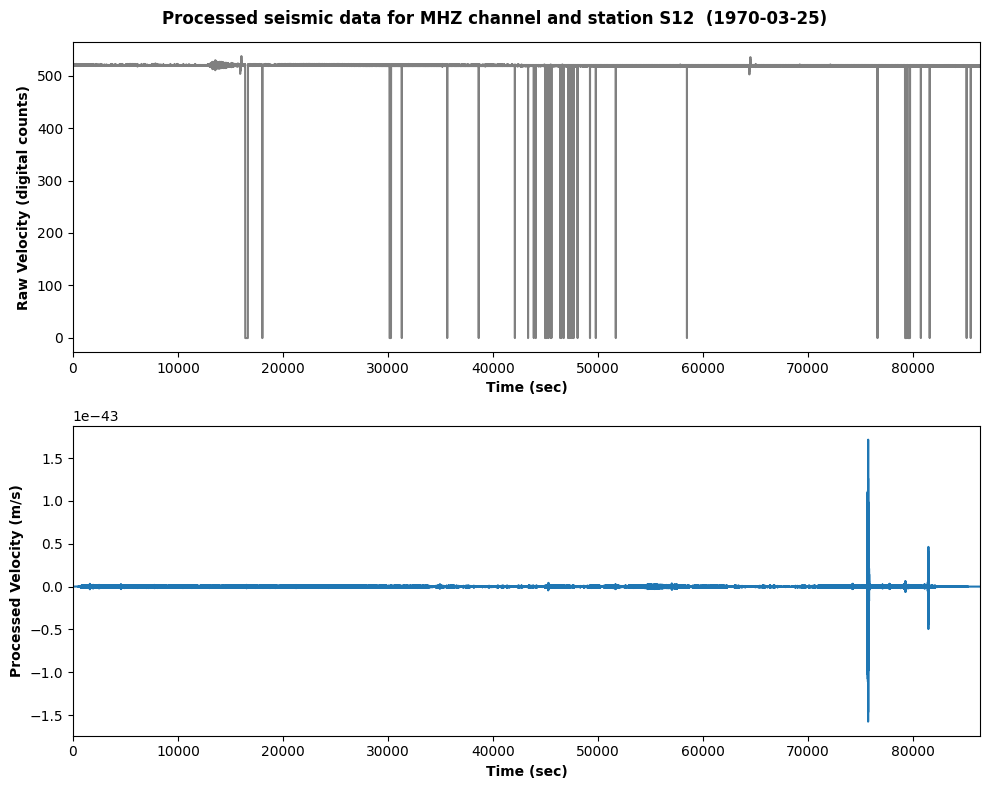

In [113]:
# Plot the result
fig = plt.figure(figsize=(10, 8))
# Plot the raw data
ax0 = plt.subplot(2, 1, 1)
ax0.plot(timedata, valdata_raw, color='gray')
ax0.set_xlim((timedata[0], timedata[-1]))
ax0.set_xlabel('Time (sec)', fontweight='bold')
ax0.set_ylabel('Raw Velocity (digital counts)', fontweight='bold')

# Plot the processed data
ax1 = plt.subplot(2, 1, 2)
ax1.plot(proctime, procdata)
ax1.set_xlim((proctime[0], proctime[-1]))
ax1.set_xlabel('Time (sec)', fontweight='bold')
ax1.set_ylabel('Processed Velocity (m/s)', fontweight='bold')
fig.suptitle(f'Processed seismic data for {channame} channel and station {station}  ({day})', fontweight='bold')
fig.tight_layout()

Compute Spectrograms for the data

In [114]:
# Import additional packages
from scipy import signal
from matplotlib import cm

In [115]:
# We are going to compute the seismic arrival time of an impact moonquake that occurs in this hour
# We use the term evid (event ID) to describe the arrival
# The format we will use for datetime is %Y-%m-%dT%H:%M:%S
arrival_absolute_str = '1970-03-25T3:32:00'
arrival_absolute_dt = dt.datetime.strptime(arrival_absolute_str, '%Y-%m-%dT%H:%M:%S')

# Convert it to the time in seconds after the start of the hour
arrival_rel = (arrival_absolute_dt - trace_start.datetime).seconds

In [116]:
def compute_spec(trtime, trvals):
    """
    Computes the spectrograms of the processed data

    :param trtime: [vector] Processed time values
    :param trvals: [vector] Processed velocity values
    """
    # Get the sample-rate of the processed data. If we don't have an explicit value saved, we can just use differences in the time vector
    delta_samples = trtime[1]-trtime[0]
    sampling_rate = 1/delta_samples
    
    # Compute spectrogram
    spec_f, spec_t, spec_sxx = signal.spectrogram(trvals, sampling_rate)
    
    return spec_f, spec_t, spec_sxx

# Cycle through each file 
spec_f, spec_t, spec_sxx = compute_spec(proctime, procdata)

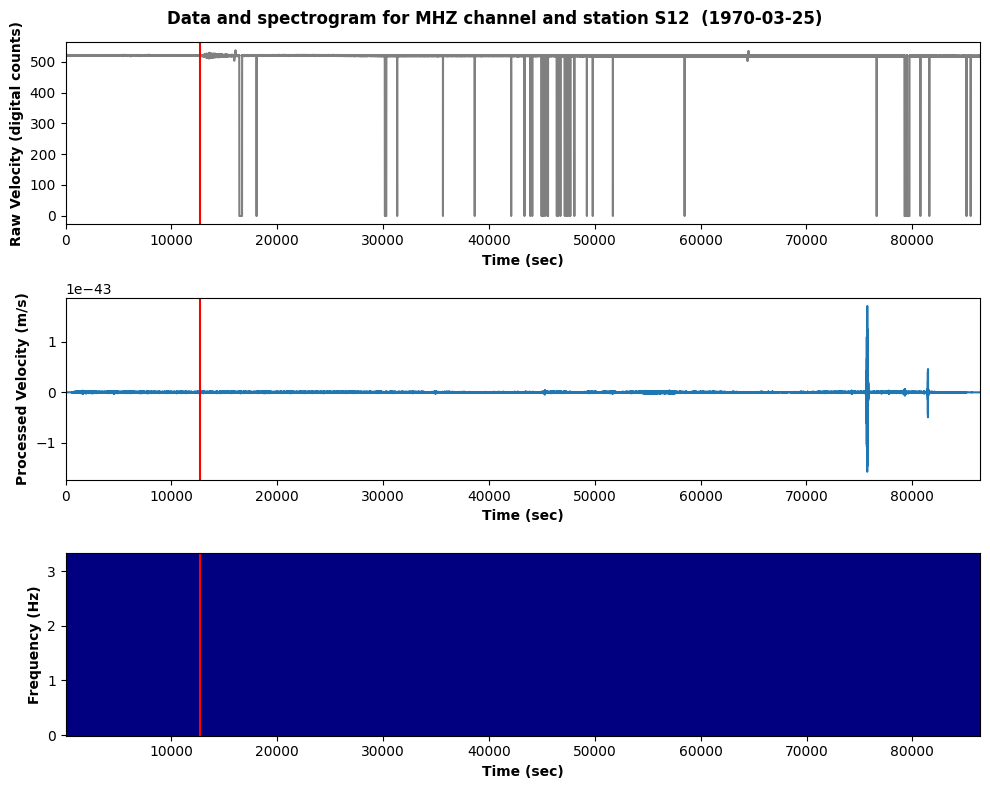

In [117]:
# Plot the result
fig = plt.figure(figsize=(10, 8))

# Plot the raw data
ax0 = plt.subplot(3, 1, 1)
ax0.plot(timedata, valdata_raw, color='gray')
ax0.set_xlim((timedata[0], timedata[-1]))
ax0.set_xlabel('Time (sec)', fontweight='bold')
ax0.set_ylabel('Raw Velocity (digital counts)', fontweight='bold')

# Plot the processed data
ax1 = plt.subplot(3, 1, 2)
ax1.plot(proctime, procdata)
ax1.set_xlim((proctime[0], proctime[-1]))
ax1.set_xlabel('Time (sec)', fontweight='bold')
ax1.set_ylabel('Processed Velocity (m/s)', fontweight='bold')

# Plot the spectrogram
ax2 = plt.subplot(3, 1, 3)
ax2.pcolormesh(spec_t, spec_f, spec_sxx, cmap=cm.jet, vmax=5e-18)
ax2.set_xlabel('Time (sec)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')

# Plot the arrivals
ax0.axvline(arrival_rel, c='red')
ax1.axvline(arrival_rel, c='red')
ax2.axvline(arrival_rel, c='red')
    
fig.suptitle(f'Data and spectrogram for {channame} channel and station {station}  ({day})', fontweight='bold')
fig.tight_layout()

## Cut and export the data

In [118]:
# Import more packages
from obspy import UTCDateTime

In [119]:
# Pick a trim length before and after the arrival (in seconds)
pre_arrival_time = 300
post_arrival_time = 5200

# Use the timedelta function to get the absolute datetime of when to cut the trace
pre_arrival_dt = arrival_absolute_dt - dt.timedelta(seconds=pre_arrival_time)
post_arrival_dt = arrival_absolute_dt + dt.timedelta(seconds=post_arrival_time)

# Obspy uses utctime, so use the UTCDateTime function to convert it to that format
pre_arrival_utc = UTCDateTime(pre_arrival_dt)
post_arrival_utc = UTCDateTime(post_arrival_dt)

In [120]:
# Set an output directory
outdir = f'{os.getcwd()}test_output/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# Cut the file
st = read(url_path)
st.trim(pre_arrival_utc, post_arrival_utc)
st.write(f'{outdir}{os.path.basename(url_path)}_cut.mseed', format='MSEED')
print(f'Cut file {os.path.basename(url_path)}_cut.mseed...')

Cut file xa.s12.00.mhz.1970.084.0.mseed_cut.mseed...
